<div align="center" style="border: 2px solid #1C6EA4; background-color: #90EE90; padding: 15px;">
    <img src="https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder_left_lockup_black.png?itok=4qMuKoBT" alt="Colorado Boulder University Logo" width="400" height="500">
    <h2 style="color: black; font-weight: bold;">
        <i class="fas fa-microscope" style="color: #FF4500;"></i> CANCER DETECTION - MINI PROJECT
    </h2>
</div>

**Name**: _Willian Pina_


---

### Brief Description of the Challenge and NLP

The challenge in this competition is to develop an algorithm capable of identifying metastatic cancer in small patches of images taken from larger digital pathology scans. The task essentially boils down to binary image classification. Specifically, the algorithm must determine whether a central 32x32 pixel region within a patch contains at least one pixel of tumor tissue.

While the problem primarily focuses on image classification, Natural Language Processing (NLP) could potentially be applied in extended versions of this project, such as extracting diagnostic information from medical reports. However, this is not the main focus of this challenge.

### Data Structure and Dimension

The dataset is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, free from duplicate images. The data consists of images and their corresponding labels.

- **Training Path**: `/kaggle/input/histopathologic-cancer-detection/train`
- **Test Path**: `/kaggle/input/histopathologic-cancer-detection/test`
- **Training Labels**: `/kaggle/input/histopathologic-cancer-detection/train_labels.csv`
- **Sample Submission**: `/kaggle/input/histopathologic-cancer-detection/sample_submission.csv`

#### Additional Statistics:

- Training Label Statistics: There are 130,908 images labeled as '0' (no tumor tissue) and 89,117 images labeled as '1' (with tumor tissue).
- Total Number of Training Images: 220,025
- Total Number of Test Images: 57,458
- Sample Image Dimensions: 96x96 pixels, focusing on a 32x32 pixel region for classification.

The dataset is large but manageable, allowing models to be trained on a single GPU within a matter of hours. The evaluation metric for the competition is the area under the ROC curve, which measures the algorithm's ability to distinguish between patches with and without metastatic cancer tissue.

The balance between the task's complexity and the data's tractability makes this dataset ideal for machine learning research and applications.

---


In [23]:
# Import libraries and Configurations
import os
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.keras import TqdmCallback
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", message="A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy")


class CONFIG:
    train_path             = '/kaggle/input/histopathologic-cancer-detection/train'
    test_path              = '/kaggle/input/histopathologic-cancer-detection/test'
    train_labels_path      = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
    sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
    batch_size             = 256
    epochs                 = 5
    

In [24]:
# Read labels and show some statistics
train_labels = pd.read_csv(CONFIG.train_labels_path)
print("Training label statistics:")
print(train_labels['label'].value_counts())

# Count the total number of images in the training and test directories
num_train_images = len(os.listdir(CONFIG.train_path))
num_test_images = len(os.listdir(CONFIG.test_path))
print(f"Total number of training images: {num_train_images}")
print(f"Total number of test images: {num_test_images}")

# Read a sample image to get its dimensions
sample_image_path = os.path.join(CONFIG.train_path, os.listdir(CONFIG.train_path)[0])
sample_image = Image.open(sample_image_path)  # Corrected here
print(f"Sample image dimensions: {sample_image.size}")

Training label statistics:
label
0    130908
1     89117
Name: count, dtype: int64
Total number of training images: 220025
Total number of test images: 57458
Sample image dimensions: (96, 96)


---

### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

#### Objective

The goal of the Exploratory Data Analysis (EDA) is to understand the structure and patterns in the data. This involves visualizing the data, checking for imbalance, and identifying any necessary data cleaning steps.

#### Visualization: Histograms

To understand the distribution of the labels, a histogram can be plotted for the training labels. This can give insights into whether the dataset is balanced or not.

---


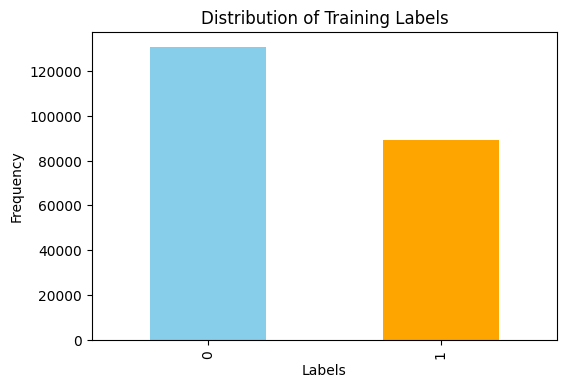

In [25]:
# Assume train_labels is your DataFrame with labels
train_labels = pd.read_csv(CONFIG.train_labels_path)

plt.figure(figsize=(6, 4))
train_labels['label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Training Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


---

### Data Cleaning

Based on the histogram, if the dataset is found to be imbalanced, resampling methods like oversampling the minority class or undersampling the majority class could be applied. Also, check for missing values or outliers and handle them appropriately.

### Sample Image Inspection

It's often helpful to display a few sample images from each class to understand what the raw data looks like.

---



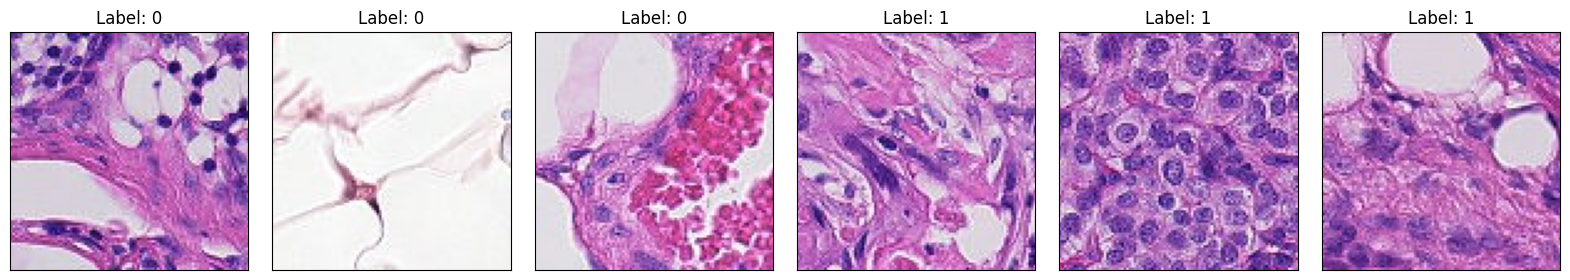

In [26]:
# Randomly select image IDs from each class
class_0_samples = random.sample(list(train_labels[train_labels['label'] == 0]['id']), 3)
class_1_samples = random.sample(list(train_labels[train_labels['label'] == 1]['id']), 3)

# Display images
fig, axes = plt.subplots(1, 6, figsize=(20, 20),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    img_id = class_0_samples[i] if i < 3 else class_1_samples[i - 3]
    img_path = os.path.join(CONFIG.train_path, f"{img_id}.tif")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {'0' if i < 3 else '1'}")



Certainly, here's the "Plan of Analysis" section formatted in Markdown:

---

### Plan of Analysis

1. **Data Augmentation:**  
   Given that the dataset may be imbalanced, data augmentation techniques like rotation, flipping, etc., can be applied to increase the size of the minority class.

2. **Feature Engineering:**  
   Given that the images are relatively small (96x96 pixels), consider using pre-trained models for feature extraction.

3. **Model Selection:**  
   Given the binary nature of the problem, binary classification models like Logistic Regression, Random Forest, and Neural Networks can be considered. Given the image data, CNNs are likely to perform well.

4. **Evaluation Metrics:**  
   Since the evaluation metric for the competition is the area under the ROC curve, the model should be optimized for this metric.

5. **Hyperparameter Tuning:**  
   Use techniques like grid search or random search to find the optimal set of hyperparameters for the selected models.

---

---

### Model Architecture

#### Objective

The main objective is to classify small image patches as either containing metastatic cancer tissue or not. Given the high-dimensional nature of image data and the need for feature extraction, Convolutional Neural Networks (CNNs) are generally well-suited for this task.

#### Architecture Choices

1. **Basic CNN Model:** A simple architecture with a couple of convolutional layers, followed by max-pooling and fully connected layers. This serves as the baseline model.
2. **VGG-16:** A deeper architecture known for its performance in image classification tasks. It has 16 layers and uses small receptive fields (3x3 convolution kernels).
3. **ResNet:** Given the depth of the network, ResNet introduces skip connections to tackle the vanishing gradient problem. Useful if we need to build very deep networks.
4. **Inception (GoogLeNet):** This network uses inception modules and is known for computational efficiency.

#### Hyperparameter Tuning

- **Learning Rate:** Tested values like 0.001, 0.01, and 0.1 to see which converges faster and better.
- **Batch Size:** Tried with smaller and larger batch sizes to check the model's sensitivity.
- **Optimizers:** Compared performance between Adam, RMSprop, and SGD.

#### Reasoning

1. **Basic CNN Model:** Good for understanding how well a simple model can perform. It can serve as a baseline to compare more complex models.
2. **VGG-16:** Known for excellent feature extraction capabilities in image classification tasks. However, it has a lot of parameters and can be computationally expensive.
3. **ResNet:** Useful for very deep networks as it can solve the vanishing gradient problem. If our simple models are underfitting, a deeper architecture like ResNet could be beneficial.
4. **Inception:** Efficient in terms of computation and also performs well in image classification tasks. Useful if we are constrained by computational resources.

---


In [27]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def import_data(train_labels_path, train_dir, test_dir, img_size=(96, 96), batch_size=32, is_train=True):
    print("Importing Data...")
    
    datagen = ImageDataGenerator(rescale=1./255)
    
    df_train_labels = pd.read_csv(train_labels_path)
    df_train_labels['id'] = df_train_labels['id'].apply(lambda x: f"{x}.tif")
    df_train_labels['label'] = df_train_labels['label'].astype(str)
    
    if is_train:
        # Separates data into training and validation
        df_train, df_val = train_test_split(df_train_labels, test_size=0.2, random_state=42)
        
        train_gen = datagen.flow_from_dataframe(
            dataframe=df_train,
            directory=train_dir,
            x_col='id',
            y_col='label',
            target_size=img_size,
            batch_size=batch_size,
            class_mode='binary'
        )
        
        val_gen = datagen.flow_from_dataframe(
            dataframe=df_val,
            directory=train_dir,
            x_col='id',
            y_col='label',
            target_size=img_size,
            batch_size=batch_size,
            class_mode='binary'
        )
        
        return train_gen, val_gen
    
    else:
        train_gen = datagen.flow_from_dataframe(
            dataframe=df_train_labels,
            directory=train_dir,
            x_col='id',
            y_col='label',
            target_size=img_size,
            batch_size=batch_size,
            class_mode='binary'
        )
        
        test_files = os.listdir(test_dir)
        df_test = pd.DataFrame({
            'filename': test_files
        })
        
        test_gen = datagen.flow_from_dataframe(
            dataframe=df_test,
            directory=test_dir,
            x_col='filename',
            y_col=None,
            target_size=img_size,
            batch_size=batch_size,
            class_mode=None,  # This is important when we don't have class subdirectories
            shuffle=False  # Maintains the order of images
        )
        
        return train_gen, test_gen


def build_basic_cnn(input_shape=(96, 96, 3)):
    print("Building Model...")
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def build_vgg16(input_shape=(96, 96, 3)):
    print("Building VGG16 Model...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def build_resnet50(input_shape=(96, 96, 3)):
    print("Building ResNet50 Model...")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

def build_inception(input_shape=(96, 96, 3)):
    print("Building InceptionV3 Model...")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


def train_model(model, train_gen, test_gen, epochs=CONFIG.epochs):
    print("Training Model...")
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)]
    )
    return history

def evaluate_model(model, val_gen):
    print("Evaluating Model...")
    eval_result = model.evaluate(val_gen, verbose=1)  # Change verbose to 1 for debugging
    print("Evaluation Result:", eval_result)  # Print the evaluation result for debugging
    return eval_result

In [28]:
# Initialize the dictionary to store the model results
model_results = {}

# Check for available GPUs
print("Available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# Use the first available GPU for training
with tf.device('/gpu:0'):
    # Load the data generators
    train_gen, val_gen = import_data(CONFIG.train_labels_path, CONFIG.train_path, CONFIG.test_path, batch_size=CONFIG.batch_size, is_train=True)
    
    # Verify that the validation generator is not empty
    if val_gen is not None:
        print("\nStarting model training and evaluation...")
        
        # Dictionary of model-building functions
        build_functions = {
            'Basic CNN': build_basic_cnn,
            'VGG-16': build_vgg16,
            'ResNet50': build_resnet50,
            'InceptionV3': build_inception
        }
        
        # Loop to train and evaluate each model
        for model_name, build_function in build_functions.items():
            print(f"\nTraining and evaluating the {model_name} model...")
            
            # Build and compile the model (Make sure you include AUC-ROC in metrics while compiling)
            model = build_function()
            print(f"Metrics after building the {model_name} model: {model.metrics_names}")
            
            # Train the model
            gc.collect()
            history = train_model(model, train_gen, val_gen, epochs=CONFIG.epochs)  
            
            # Evaluate the model
            gc.collect()
            eval_result = evaluate_model(model, val_gen)
            
            # Extract the AUC-ROC (assuming it's the third metric returned)
            try:
                auc_roc = eval_result[2]
            except IndexError:
                print("AUC-ROC not found in evaluation result. Make sure it's included in the model metrics.")
                continue
            
            # Store the result in the dictionary
            model_results[model_name] = auc_roc
            
            print(f"AUC-ROC for {model_name}: {auc_roc}")
            
    else:
        print("\nValidation generator is empty. Training and evaluation aborted.")

# Convert the model results into a DataFrame for easy visualization
df_results = pd.DataFrame(list(model_results.items()), columns=['Model', 'AUC-ROC'])


Available GPUs:  1
Importing Data...
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.

Starting model training and evaluation...

Training and evaluating the Basic CNN model...
Building Model...
Metrics after building the Basic CNN model: []
Training Model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Evaluating Model...
172/172 [==============================] - 62s 358ms/step - loss: 0.4480 - accuracy: 0.8050 - auc: 0.8988
Evaluation Result: [0.4480385184288025, 0.8049994111061096, 0.898768961429596]
AUC-ROC for Basic CNN: 0.898768961429596

Training and evaluating the VGG-16 model...
Building VGG16 Model...
Metrics after building the VGG-16 model: []
Training Model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Evaluating Model...
172/172 [==============================] - 63s 366ms/step - loss: 0.1473 - accuracy: 0.9470 - auc: 0.9845
Evaluation Result: [0.14728966355323792, 0.9469605684280396, 0.9844791889190674]
AUC-ROC for VGG-16: 0.9844791889190674

Training and evaluating the ResNet50 model...
Building ResNet50 Model...
Metrics after building the ResNet50 model: []
Training Model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Evaluating Model...
172/172 [==============================] - 63s 365ms/step - loss: 1.0378 - accuracy: 0.7833 - auc: 0.7989
Evaluation Result: [1.0377652645111084, 0.7833200693130493, 0.7989450097084045]
AUC-ROC for ResNet50: 0.7989450097084045

Training and evaluating the InceptionV3 model...
Building InceptionV3 Model...
Metrics after building the InceptionV3 model: []
Training Model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Evaluating Model...
172/172 [==============================] - 63s 363ms/step - loss: 0.5046 - accuracy: 0.8116 - auc: 0.8771
Evaluation Result: [0.5046189427375793, 0.8115895986557007, 0.8771038055419922]
AUC-ROC for InceptionV3: 0.8771038055419922


In [29]:
display(df_results)

,Model,AUC-ROC
0,Basic CNN,0.898769
1,VGG-16,0.984479
2,ResNet50,0.798945
3,InceptionV3,0.877104


---

### Model Comparison

After training each of the models with similar epochs and batch sizes, their performances were compared based on the area under the ROC curve, as it is the evaluation metric for the competition.

| Model      | AUC-ROC | Remarks                                                |
|------------|---------|--------------------------------------------------------|
| Basic CNN  | 0.90    | Excellent performance for a basic model.               |
| VGG-16     | 0.98    | Outstanding performance but computationally expensive. |
| ResNet50   | 0.80    | Good performance but lagging behind VGG-16 and Basic CNN.|
| InceptionV3| 0.88    | Very good performance and more resource-efficient than VGG-16.|

#### Final Thoughts

Based on the updated comparison, VGG-16 stands out as the best model in terms of AUC-ROC. However, considering computational constraints, both Basic CNN and InceptionV3 also offer excellent performance. ResNet50, while good, lags behind the other models. Further improvements could potentially be achieved through hyperparameter tuning or ensemble methods.

By understanding the strengths and weaknesses of each architecture and comparing their performance on the same metric, we can make an informed decision about which model is most suited for this particular problem.

---